# Redes neuronales convolucionales en Python con Keras

Implementaremos una red neuronal convolucional (CCN) en Python con Keras, y veremos cómo eludir el sobreajuste (_overfitting_) utilizando _dropout_.

Este tutorial está adaptado de [Convolutional Neural Networks in Python with Keras](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python) de [Aditya Sharma](https://www.datacamp.com/profile/adityasharma101993).

## Redes neuronales convolucionales: introducción

Las redes neuronales convolucionales, a las que nos referiremos como CNN por su sigla en inglés, son un tipo especial de redes neuronales profundas, del tipo perceptrón multicapa (MLP) o _feed forward_, denominados así debido a que la información fluye hacia adelante, desde la capa _input_ hasta la _output_, sin que haya conexiones en que las salidas de las neuronas se conviertan en entradas de las mismas.

Las CNNs están inspiradas en la [corteza visual biológica](https://es.wikipedia.org/wiki/Corteza_visual), o córtex visual, que posee pequeñas regiones de células que son sensibles a áreas específicas del campo visual.

Esta idea se reforzó a partir del experimento realizado por [Hubel y Wiesel en 1962](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1359523/). En este experimento (del que hay un [video interesante](https://youtu.be/Cw5PKV9Rj3o)), los investigadores demostraron que algunas neuronas individuales en el cerebro se activaban o disparaban solo en presencia de bordes con una orientación particular (verticales u horizontales). Por ejemplo, algunas neuronas se disparan cuando se exponen a lados verticales y otras cuando se les muestra un borde horizontal. Hubel y Wiesel descubrieron que todas estas neuronas estaban bien ordenadas en forma de columnas y que juntas podían generar la percepción visual. Esta idea de componentes especializados dentro de un sistema que tienen tareas específicas es la que da origen a las CNN.

Las CNN constituyen una de las innovaciones de mayor influencia en el campo de la visión por computadora, ya que logran desempeños muy superiores a los de la visión computacional tradicional. Estas redes neuronales han sido probadas exitosamente en muchas aplicaciones en el mundo real, tales como:

- Clasificación de imágenes, detección de objetos, segmentación, reconocimiento facial.
- Control de vehículos autónomos.
- Clasificación de estructuras cristalinas.
- [Dispersión de microondas](https://arxiv.org/abs/1908.10424)
- Sistemas de seguridad y prevención de intrusiones.
- Etc.

El primer éxito de aplicación fue en 2012, cuando Alex Krizhevsky usó CNNs para ganar la competencia ImageNet de ese año, reduciendo el error de clasificación de 26% a 15%. La competencia ImageNet (_ImageNet Large Scale Visual Recognition Challenge_ - ILSVRC) comenzó en el año 2010, y se realiza anualmente. El ella los equipos de investigación reciben conjuntos de datos con el propósito de alcanzar la mayor precisión en diversas tareas de reconocimiento visual. 

En esa época se inició la "tercera ola de las redes neuronales", Las otras dos fueron entre la década del 40 y la del 60, y entre las décadas de los 70's y 80's.

El esquema general de una CNN es el siguiente (imagen de [Wikimedia](https://commons.wikimedia.org/wiki/File:Typical_cnn.png)):

![CNN](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

La red tiene como _input_ una imagen, que luego es procesada a través de múltiples convoluciones, submuestreo, una capa completamente conectada, y finalmente un _output_.

La capa de convolución calcula la salida de neuronas que están conectadas a regiones locales, o campos receptivos, en el _input_, a través del producto escalar de sus pesos y el pequeño campo receptivo al que están conectadas en el _input_. Cada cálculo produce la extracción de un mapa de características (_features_) de la imagen de entrada. En otras palabras, podemos imaginar que tenemos una imagen representada como una matriz de valores de 5x5, y tomamos una matriz de 3x3 y deslizamos esa ventana o núcleo (_kernel_) de 3x3 por toda la imagen. En cada posición de esa matriz, multiplicamos los valores de la ventana de 3x3 por los valores de la imagen que están siendo cubiertos actualmente por la ventana. Como resultado, obtendremos un solo número que representa todos los valores en esa ventana de las imágenes. Utilizamos esta capa para filtrar: a medida que la ventana se mueve sobre la imagen, comprobamos si hay patrones en esa sección de la imagen. Se puede ver [aquí](https://poloclub.github.io/cnn-explainer/) una animación del funcionamiento de los filtros y el significado de algunos hiperparámetros.

El objetivo del submuestreo es obtener una representación de la entrada reduciendo sus dimensiones, lo que ayuda a reducir el sobreajuste. Una de las técnicas de submuestreo es la combinación máxima (_max pooling_). Con esta técnica, se selecciona el valor de píxel más alto de una región en función de su tamaño. En otras palabras, la combinación máxima toma el valor más grande de la ventana de la imagen que actualmente cubre el kernel. Por ejemplo, puede tener una capa de agrupación máxima de tamaño 2 x 2 que seleccionará el valor máximo de intensidad de píxeles de la región 2 x 2. La capa de agrupación funciona de manera muy similar a la capa de convolución. Se toma un kernel o una ventana y se lo mueve sobre la imagen, la única diferencia es que la función que se aplica al kernel y la ventana de la imagen no es lineal.

![Max pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png) Max Pooling de [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)

Finalmente, el objetivo de una capa completamente conectada es la de aplanar las características de alto nivel que se aprenden mediante las capas convolucionales, y combinar todas las características. Pasa la salida aplanada a la capa de salida donde usa un clasificador softmax o un sigmoide para predecir la etiqueta de clase de entrada.

## Habilitación y verificación de GPU

Primero necesitamos habilitar una GPU para el _notebook_. Para ello, hay que acceder al menú: Editar / Configuración del notebook, y seleccionar GPU del menú desplegable "Acelerador de hardware".

Luego, confirmamos que podemos conectar la GPU con tensorflow


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Conjunto de datos Fashion-MNIST

El dataset Fashion-MNIST es un conjunto de imágenes de artículos de [Zalando](https://arxiv.org/abs/1708.07747) en escala de grises de 28x28. Consiste en 70.000 productos de indumentaria agrupados en 10 categorías, y 7.000 imágenes por categoría. El conjunto de entrenamiento tiene 60.000 imágenes y el de verificación tiene 10.000.

Este dataset es similar al MNIST que usó Ramiro en el segundo encuentro para clasificar dígitos escritos a mano. Esto significa que las dimensiones de las imágenes, y las divisiones de entrenamiento y verificación son similares al del dataset MNIST.

Keras tiene una biblioteca denominada `datasets` que se puede utilizar para obtener conjuntos de datos de prueba. Las imágenes de entrenamiento y prueba, junto con las etiquetas, se guardan en las variables `train_X`, `train_Y`, `test_X` y `test_Y`, respectivamente:

In [2]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

## Análisis de los datos

Analizaremos cómo es la estructura de datos en el dataset. Aunque ya sabemos la dimensión de las imágenes, es útil analizarlo programáticamente, ya que nos permite reescalar las imágenes.

In [3]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


De la salida anterior podemos ver que los datos de entrenamiento tienen una forma de 60.000 x 28 x 28, dado que hay 60.000 muestras de entrenamiento, cada una de dimensiones 28 x 28. Del mismo modo, los datos de prueba tienen una forma de 10.000 x 28 x 28, dado que hay 10.000 muestras de prueba.

In [4]:
# Encontrar los valores únicos de las etiquetas de entrenamiento
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Tenemos un total de 10 clases de salida en el rango de 0 a 9.

Vamos a ver algunas imágenes en el dataset:

Text(0.5, 1.0, 'Categoría : 9')

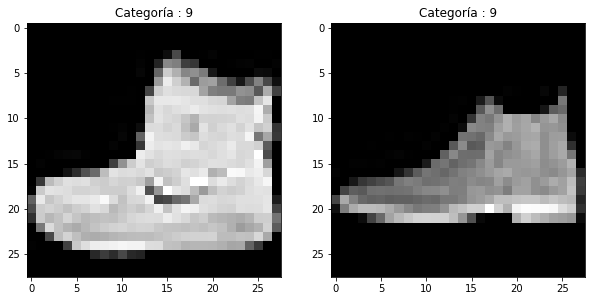

In [5]:
plt.figure(figsize=[10,10])
im_idx = 0
# Mostramos la imagen im_idx en los datos de entrenamiento
plt.subplot(121)
plt.imshow(train_X[im_idx,:,:], cmap='gray')
plt.title("Categoría : {}".format(train_Y[im_idx]))

# Mostramos la primera imagen en los datos de prueba
plt.subplot(122)
plt.imshow(test_X[im_idx,:,:], cmap='gray')
plt.title("Categoría : {}".format(test_Y[im_idx]))

La salida de los dos gráficos anteriores parece una zapatilla, y a esta clase se le asigna una etiqueta de clase de 9. De manera similar, otros productos de indumentaria tendrán diferentes etiquetas, pero productos similares tendrán las mismas etiquetas. Esto significa que las 7.000 imágenes de zapatillas tendrán una etiqueta de clase de 9.

## Procesamiento de datos

Como se puede ver en el gráfico anterior, las imágenes son están en escala de grises con valores de píxeles que van de 0 a 255. Además, estas imágenes tienen una dimensión de 28 x 28. Como resultado, debemos preprocesar los datos antes de introducirlos en el modelo.

Como primer paso, convertimos cada imagen de 28 x 28 de los conjuntos de entrenamiento y de prueba en una matriz de tamaño 28 x 28 x 1, que se alimenta a la red en la capa _input_.

In [6]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Actualmente los datos se encuentran en un formato `int8 por lo que antes de pasarlos a la red hay que convertirlos en `float32 y reescalar los valores de los pixeles en el rango [0, 1]:

In [7]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Ahora necesitamos convertir las etiquetas de clase en un vector de codificación [_one-hot_](https://es.wikipedia.org/wiki/One-hot).

En la codificación one-hot, los datos categóricos se convierten en un vector de números. Esto es porque los algoritmos de aprendizaje automático no pueden trabajar directamente con datos categóricos. Se genera una columna booleana para cada categoría o clase. Solo una de estas columnas podría tomar el valor 1 para cada muestra. De ahí el término codificación _one-hot_.

Para el planteamiento del problema, la única codificación activa será un vector de fila, y para cada imagen, tendrá una dimensión de 1 x 10. Lo importante a tener en cuenta aquí es que el vector consta de todos ceros, excepto por la clase que representa, en la cual toma el valor 1. Por ejemplo, la imagen de la zapatilla de arriba tiene una etiqueta de 9, por lo que para todas las imágenes de zapatillas, el vector de codificación _one-hot_ [0 0 0 0 0 0 0 0 0 1].

In [8]:
# Cambio de las etiquetas de categóricas a codificacióón one-hot
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Mostramos el cambio de las etiquetas de categoría por codificación one-hot
print('Etiqueta original:', train_Y[0])
print('Después de la codificación one-hot:', train_Y_one_hot[0])
print(train_Y_one_hot.shape)


Etiqueta original: 9
Después de la codificación one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(60000, 10)


En el aprendizaje automático o cualquier tarea específica de datos, se debe particionar los datos correctamente. Para que el modelo generalice bien, vamos a dividir los datos de entrenamiento en dos partes, una diseñada para entrenamiento y otra para validación. En este caso, entrenaremos el modelo en el 80% de los datos de entrenamiento y lo validaremos en el 20% de los datos de entrenamiento restantes. Esto también ayudará a reducir el sobreajuste, ya que estaremos validando el modelo con los datos que no habría visto en la fase de entrenamiento, lo que ayudará a mejorar el rendimiento de sobre los datos de prueba. Recordemos que el conjunto total de datos se particiona del siguiente modo:
```
########################### ----------   |    ++++++
       Entrenamiento        Validación   |    Prueba
                                         |
--------------------------------------   |    ------
               Aprendizaje               |     Final
``` 

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

## La red

Las imágenes originales tienen un tamaño de 28 x 28. Convertimos la matriz de la imagen en un array, lo rescalamos entre 0 y 1, lo modificamos para que tenga un tamaño de 28 x 28 x 1 y finalmente lo alimentamos como una _input_ a la red.

Usaremos tres capas convolucionales:

- La primera capa tendrá 32 filtros de 3 x 3,
- La segunda capa tendrá 64 filtros de 3 x 3 y
- La tercera capa tendrá 128 filtros de 3 x 3.

Además, hay tres capas de combinación máxima (_max-pooling_), cada una de tamaño 2 x 2.

![red](https://raw.githubusercontent.com/gmg-utn/machine-learning/master/encuentro_03/fashion-mnist-architecture.png)

## El modelo

Importamos primero los módulos necesarios para entrenar el modelo:

In [10]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Utilizaremos un tamaño de batch de 64. Con un batch mayor de 128 o 256 podemos tener mejores resultados, pero depende de la memoria disponible. El tamaño del batch contribuye a determinar los parámetros de aprendizaje y afecta la precisión de la predicción. Entrenaremos a la red durante 20 épocas.

In [11]:
batch_size = 64
epochs = 20
num_classes = 10

## Arquitectura de la red neuronal

En Keras, se puede construir la red agregando la capa deseada una por una. Primero agregaremos una capa convolucional con `Conv2D()`. Usamos esta función porque estamos trabajando con imágenes. A continuación, agregamos la función de activación Leaky ReLU. Estas funciones de activación intentan solucionar el problema de las unidades lineales rectificadas (ReLU) que mueren, en lo que se conoce como [problema de desvanecimiento del gradiente](https://es.wikipedia.org/wiki/Problema_de_desvanecimiento_de_gradiente). La función de activación de ReLU se utiliza mucho en arquitecturas de redes neuronales y más específicamente en redes convolucionales, donde ha demostrado ser más eficaz que la función sigmoidea logística utilizada ampliamente. Desde 2017, esta función de activación es la más popular para redes neuronales profundas. La función ReLU permite establecer un umbral de activación en cero. Sin embargo, durante el entrenamiento, las unidades ReLU pueden "morir". Esto puede suceder cuando un gradiente grande fluye a través de una neurona ReLU: puede hacer que los pesos se actualicen de tal manera que la neurona nunca más se active en ningún punto de datos. Si esto sucede, entonces el gradiente que fluye a través de la unidad será siempre cero a partir de ese punto. Los ReLU con fugas intentan resolver esto: la función no será cero, sino que tendrá una pequeña pendiente negativa. La expresión que calcula la activación Leaky ReLU es:
$$ f(x) = \begin{cases}
x,  &\text{si } x > 0,\\
0.01x,& \text{si }  x \leq 0
\end{cases} $$

A continuación, agregaremos la capa de agrupación máxima con `MaxPooling2D()`, y así sucesivamente. La última capa es una capa `Dense` que tiene una función de activación softmax con 10 unidades, que es necesaria para este problema de clasificación de clases múltiples.

In [12]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))


## Compilación del modelo

Una vez creado el modelo, lo compilamos utilizando el optimizador [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), uno de los algoritmos de optimización más populares. El trabajo que describe el algortimo se puede ver en [arXiv](https://arxiv.org/abs/1412.6980), pero básicamente consiste en ajustar las actualizaciones de los parámetros utilizando los promedios de los gradientes y segundos momentos de los gradientes. Dados los parámetros $w^(t)$ y función de pérdida $L^{(t)}$, donde $t$ representa el índice de la iteración de entrenamiento, la actualización de parámetros Adam está dada por:

$$ m_w^{(t+1)} \leftarrow \beta_1 m_w^{(t)} + (1 - \beta_1) \nabla_w L^{(t)} $$
$$ v_w^{(t+1)} \leftarrow \beta_2 v_w^{(t)} + (1 - \beta_2) (\nabla_w L^{(t)})^2 $$
$$ \hat{m}_w = \frac{m_w^{(t+1)}}{1- \beta_1^{t+1}} $$
$$ \hat{v}_w = \frac{m_w^{(t+1)}}{1- \beta_2^{t+1}} $$
$$ w^{(t+1)} \leftarrow w^{(t)} - \alpha \frac{\hat{m}_w}{\sqrt{\hat{v}_w} + \epsilon} $$ 
donde $\epsilon$ es un escalar pequeño ($\sim 10^{-8}$) usado para prevenir una división por cero, $\beta_1$ ($\in [0,1), \sim 0.9$) y $\beta_2$ ($\in [0,1), \sim 0.999$) son los factores "de olvido" del gradiente y segundo momento del gradiente. Como es usual, $\alpha$ es la tasa de aprendizaje ($\sim 0.001$). Todas las operaciones sobre vectores son elemento por elemento (_element wise_).

Las características que presenta este optimizador son:
- Simple de implementar
- Eficiente computacionalmente
- Pocos requerimientos de memoria
- Invariante ante el cambio de escala diagonal de los gradientes
- Conveniente para problemas "grandes" en términos de datos y/o parámetros
- Apropiado para objetivos no-estacionarios
- Apropiado para problemas con mucho ruido o gradientes ralos
- Hiperparámetros con interpretación intuitiva y que usualmente requieren poca configuración

Además, especificamos el tipo de función de pérdida, que es la entropía cruzada categórica que se utiliza para la clasificación de clases múltiples (también se puede utilizar la entropía cruzada binaria como función de pérdida). Por último, especificamos las métricas como medida de precisión que analizaremos mientras el modelo se está entrenando.

In [13]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [14]:
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         7

## Entrenamiento del modelo

Es momento de entrenar el modelo con la función `fit()` de Keras, durante 20 épocas. La función `fit()` devolverá un objeto `history`, que utilizaremos sobre `fashion_train` para trazar los gráficos de la función de precisión y pérdida entre el entrenamiento y la validación, lo que ayudará a analizar visualmente el rendimiento del modelo.

In [15]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4622 - accuracy: 0.8316 - val_loss: 0.3207 - val_accuracy: 0.8846
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.2854 - accuracy: 0.8948 - val_loss: 0.3006 - val_accuracy: 0.8910
Epoch 3/20
750/750 [==============================] - 3s 5ms/step - loss: 0.2392 - accuracy: 0.9133 - val_loss: 0.2644 - val_accuracy: 0.9047
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2067 - accuracy: 0.9244 - val_loss: 0.2481 - val_accuracy: 0.9092
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.1827 - accuracy: 0.9325 - val_loss: 0.2200 - val_accuracy: 0.9198
Epoch 6/20
750/750 [==============================] - 3s 5ms/step - loss: 0.1591 - accuracy: 0.9404 - val_loss: 0.2412 - val_accuracy: 0.9173
Epoch 7/20
750/750 [==============================] - 3s 5ms/step - loss: 0.1388 - accuracy: 0.9479 - val_loss: 0.2481 - val_accuracy: 0.9163
Epoch 

Después de entrenar el modelo sobre el dataset fashion-MNIST por 20 épocas, y observando la precisión y pérdida en el conjunto de entrenamiento, vemos que el ajuste es bueno ya que la precisión es de casi el 99% y la pérdida menos del 3%. 

Sin embargo parece que hay sobrajuste, porque la pérdida en el conjunto de validación es de casi el 45% y la precisión es 92%. El sobreajuste parece indicar que la red memorizó los datos de entrenamiento muy bien, pero no garantiza que pueda predecir los datos que no ha visto, y éste es el origen de la diferencia entre los datos de entrenamiento y validación.

Abordaremos esto más adelante agregando capas _dropout_, pero primero evaluaremos el desempeño del modelo sobre el conjunto de prueba.

## Evaluación del modelo sobre el conjunto de prueba

In [16]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4625379741191864
Test accuracy: 0.9172000288963318


La precisión sobre el conjunto de prueba es muy bueno (más del 91%), pero vimos que parece haber sobreajuste. Para analizar esto vamos a graficar los resultados para los datos de entrenamiento y validación:

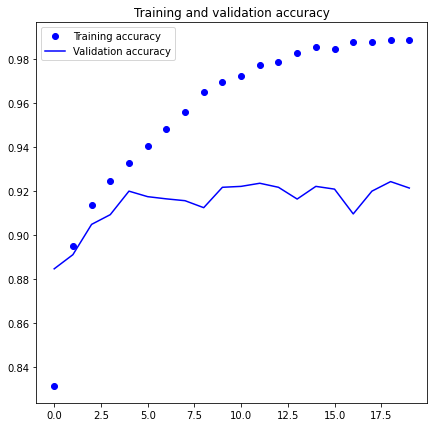

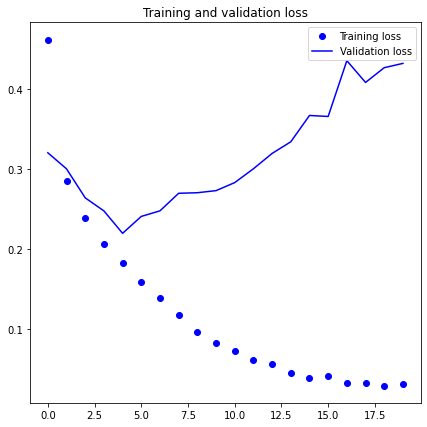

In [17]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[7,7])
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=[7,7])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

De los dos gráficos anteriores, se puede ver que la precisión de la validación casi se estancó después de 4-5 épocas y rara vez aumentó en algunas épocas. Inicialmente la precisión de la validación aumenta linealmente con la pérdida, pero luego aparece una meseta.

La pérdida en el conjunto de validación muestra señales de sobreajuste, similar a la precisión de validación: disminuye linealmente pero después de 4-5 épocas, comienza a aumentar. Esto significa que el modelo intentó memorizar los datos y tuvo éxito.


## Agregado de _dropout_ en la red

Una forma de disminuir el sobreajuste es agregar una capa de _dropout_ (abandono). _Dropout_ apaga aleatoriamente una fracción de neuronas durante el proceso de entrenamiento, lo que reduce en cierta medida la dependencia del conjunto de entrenamiento. La fracción de neuronas que se quiere desea desactivar se decide mediante un hiperparámetro, que se puede ajustar en consecuencia. De esta forma, apagar algunas neuronas no permitirá que la red memorice los datos de entrenamiento ya que no todas las neuronas estarán activas al mismo tiempo y las neuronas inactivas no podrán aprender nada.

Vamos a armar una nueva red que compilaremos y entrenaremos nuevamente, pero esta vez con _dropout_. Esta nueva red será entrenada durante 20 épocas con un tamaño de batch de 64.

In [18]:
batch_size = 64
epochs = 20
num_classes = 10

In [19]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))

In [20]:
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

In [21]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [22]:
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6165 - accuracy: 0.7715 - val_loss: 0.3778 - val_accuracy: 0.8639
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3803 - accuracy: 0.8607 - val_loss: 0.3092 - val_accuracy: 0.8852
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3355 - accuracy: 0.8753 - val_loss: 0.2913 - val_accuracy: 0.8923
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3044 - accuracy: 0.8874 - val_loss: 0.2714 - val_accuracy: 0.8988
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2846 - accuracy: 0.8943 - val_loss: 0.2513 - val_accuracy: 0.9056
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2699 - accuracy: 0.8989 - val_loss: 0.2334 - val_accuracy: 0.9143
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2586 - accuracy: 0.9026 - val_loss: 0.2410 - val_accuracy: 0.9111
Epoch 

Podemos guardar el modelo. De esta forma, podemos cargar el modelo más adelante si lo necesitamos y no tener que volver a entrenarlo. Alternativamente, podemos modificar la arquitectura e iniciar el proceso de entrenamiento. Siempre es una buena idea guardar el modelo e incluso los pesos porque ahorra tiempo. También se puede guardar el modelo después de cada época para que, si ocurre algún problema que detiene el entrenamiento en una época, no tener que iniciar el entrenamiento desde el principio.

In [23]:
fashion_model.save("fashion_model_dropout.h5py")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: fashion_model_dropout.h5py/assets


## Evaluación del modelo en el conjunto de prueba

Finalmente, evaluaremos el nuevo model y veremos su desempeño.

In [24]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.2324 - accuracy: 0.9201


In [25]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2324201464653015
Test accuracy: 0.9200999736785889


Se observa que agregar capas `dropout` mejora el desempeño. Aunque la precisión no mejora significativamente, la pérdida sobre el conjunto de prueba disminuye comparado con los resultados previos.

Veamos los gráficos de precisión y pérdida para los datos de entrenamiento y validación:

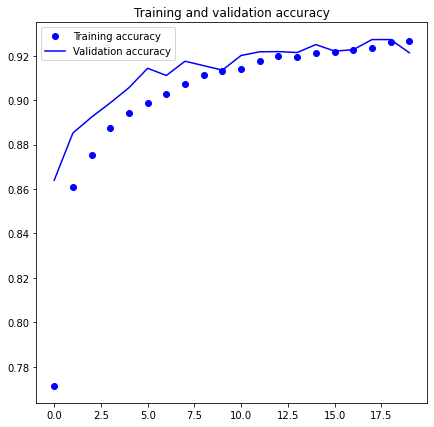

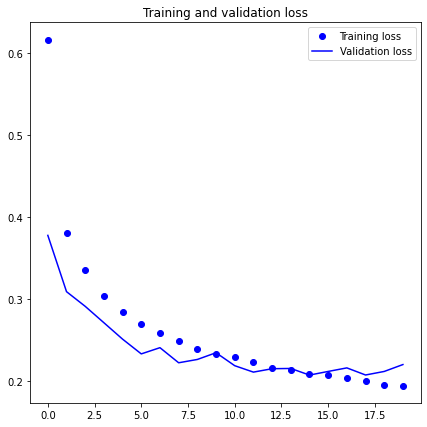

In [26]:
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[7,7])
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=[7,7])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finalmente, se puede ver que la pérdida y la precisión en el conjunto de validación están sincronizadas con la pérdida y la precisión en el conjunto de entrenamiento. Aunque la pérdida de validación y la curva de precisión no son lineales, muestra que el modelo no está sobreajustado: la pérdida de validación disminuye y no aumenta, y no hay mucha brecha entre el entrenamiento y la precisión de validación.

Por lo tanto, se puede decir que la capacidad de generalización del modelo mejoró mucho, ya que la pérdida tanto en el conjunto de prueba como en el conjunto de validación fue solo un poco mayor en comparación con la pérdida de entrenamiento.

## Predicción de etiquetas

Dado que las predicciones que se obtienen son valores de punto flotante, no será factible comparar las etiquetas predichas con etiquetas de prueba verdaderas. Por lo tanto, se debe redondea la salida que para convertir los valores de punto flotante en un número entero. Usaremos `np.argmax()` para seleccionar el número de índice que tiene un valor más alto en una fila.

Por ejemplo, supongamos que una predicción para una imagen de prueba es [0 1 0 0 0 0 0 0 0 0], la salida para esto debe ser una etiqueta de clase 1.

In [27]:
predicted_classes = fashion_model.predict(test_X)

In [28]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape

((10000,), (10000,))

Se encontraron 9170 etiquetas correctas


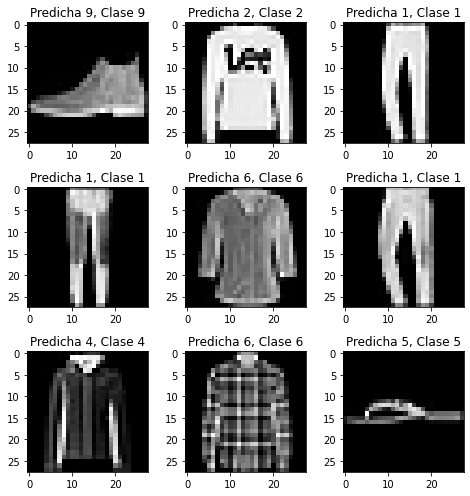

In [29]:
correct = np.where(predicted_classes==test_Y)[0]
print("Se encontraron %d etiquetas correctas" % len(correct))
plt.figure(figsize=[7,7])
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicha {}, Clase {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Se encontraron 830 etiquetas incorrectas


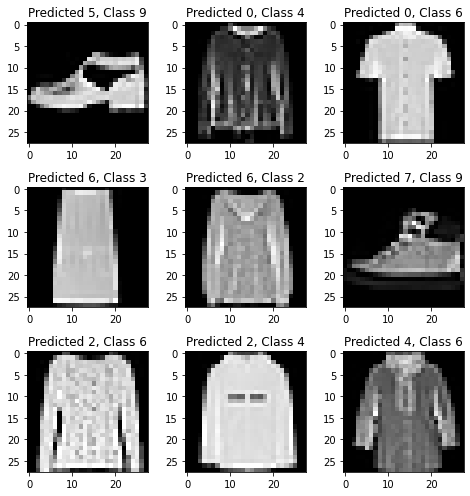

In [30]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Se encontraron %d etiquetas incorrectas" % len(incorrect))
plt.figure(figsize=[7,7])
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

Al mirar algunas imágenes, no se puede estar seguro de por qué el modelo no puede clasificar las imágenes anteriores correctamente, pero parece que una variedad de patrones similares presentes en múltiples clases afectan el rendimiento del clasificador, aunque CNN es un arquitectura robusta. Por ejemplo, las imágenes 4 y 5 pertenecen a clases diferentes pero se ven algo similares, tal vez un buzo o tal vez una camisa de manga larga.

## Informe de clasificación

El informe de clasificación puede ayudar a identificar a las clases predichas erróneamente con más detalle. Muestra las clases en las que el modelo tuvo un desempeño pobre:

In [31]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.76      0.94      0.84      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.85      0.91      0.88      1000
     Class 3       0.92      0.93      0.93      1000
     Class 4       0.89      0.86      0.88      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.89      0.64      0.74      1000
     Class 7       0.96      0.98      0.97      1000
     Class 8       0.98      0.99      0.99      1000
     Class 9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Se puede ver que el clasificador tiene un rendimiento inferior para la clase 6 en cuanto a precisión y memoria. Para las clases 0 y 2, el clasificador carece de precisión. Además, para la clase 4, el clasificador carece levemente de precisión y memoria. El siguiente diagrama ofrece una interpretación visual de los resultados de `clasification_report()` (de [Wikimedia](https://en.wikipedia.org/wiki/F1_score) )
![class_rep](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)